In [1]:
import re

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import PCA

from skopt import gp_minimize
from skopt.space import Real, Integer, Categorical
from skopt.utils import use_named_args
from skopt.plots import plot_convergence

from mlxtend.evaluate import mcnemar_table, mcnemar

from shap import Explainer
from shap.plots import waterfall, beeswarm

import warnings
warnings.filterwarnings("ignore")

/root/venv/lib/python3.9/site-packages/shap/utils/_clustering.py:35: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def _pt_shuffle_rec(i, indexes, index_mask, partition_tree, M, pos):
/root/venv/lib/python3.9/site-packages/shap/utils/_clustering.py:54: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def delta_minimization_order(all_masks, max_swap_size=100, num_pa

# Grade 4 #

In [2]:
# read cleve.mod
with open('cleve.mod', 'r') as f:
    lines = f.readlines()
f.close()
# remove the first 20 lines
lines = lines[20:]
# remove all \n in every line
lines = [line.replace('\n', '') for line in lines]
# split every line by space. Consider one or more spaces
lines = [re.split(r'\s+', line) for line in lines]
# replace all occurrences of "fal" with "false"
lines = [[word.replace('fal', 'false') for word in line] for line in lines]

In [3]:
# convert lines to a dataframe
df = pd.DataFrame(lines, columns=["age", "sex", "cp", "trestbps", "chol", "fbs", "restecg", "max_heart_rate", "exang",
                                  "oldpeak", "slope", "ca", "thal", "Sick", "delete"])
# drop the last column
df = df.drop(columns=['delete'])
# replace ? with null
df = df.replace({'?': np.nan})
# make age, trestbps, chol, max_heart_rate, oldpeak, ca numeric
df = df.apply(pd.to_numeric, errors='ignore')
# make fbs, exang binary
df = df.replace({'false': 0, 'true': 1})
# map sick to 1 and buff to 0
df = df.replace({'sick': 1, 'buff': 0})
df = df.replace({'male': 0, 'fem': 1})

In [4]:
# count number of missing values
df.isnull().sum()

age               1
sex               1
cp                1
trestbps          1
chol              1
fbs               1
restecg           1
max_heart_rate    1
exang             1
oldpeak           1
slope             1
ca                6
thal              3
Sick              1
dtype: int64

In [5]:
# drop rows with missing values
df = df.dropna()
df.shape

(296, 14)

In [6]:
# one hot encode cp, restecg, slope, thal
df = pd.get_dummies(df, columns=['cp', 'restecg', 'slope', 'thal'])
# drop rows that contain outliers in any column by std
df = df[(np.abs(df - df.mean()) / df.std()) < 3].dropna()
# standardize age, trestbps, chol, max_heart_rate, oldpeak, ca using StandardScaler
scaler = StandardScaler()
df[['age', 'trestbps', 'chol', 'max_heart_rate', 'oldpeak', 'ca']] = scaler.fit_transform(
    df[['age', 'trestbps', 'chol', 'max_heart_rate', 'oldpeak', 'ca']])

# get statistics about the dataframe
df.describe()

,age,sex,trestbps,chol,fbs,max_heart_rate,exang,oldpeak,ca,Sick,...,cp_notang,restecg_abn,restecg_hyp,restecg_norm,slope_down,slope_flat,slope_up,thal_fix,thal_norm,thal_rev
count,2.320000e+02,232.000000,2.320000e+02,2.320000e+02,232.000000,2.320000e+02,232.000000,2.320000e+02,2.320000e+02,232.000000,...,232.000000,232.0,232.000000,232.000000,232.0,232.000000,232.000000,232.0,232.000000,232.000000
mean,2.871266e-16,0.340517,-3.751788e-16,2.297013e-17,0.120690,5.321414e-16,0.318966,1.684476e-16,-1.531342e-17,0.435345,...,0.314655,0.0,0.465517,0.534483,0.0,0.461207,0.538793,0.0,0.599138,0.400862
std,1.002162e+00,0.474908,1.002162e+00,1.002162e+00,0.326471,1.002162e+00,0.467083,1.002162e+00,1.002162e+00,0.496874,...,0.465382,0.0,0.499888,0.499888,0.0,0.499571,0.499571,0.0,0.491133,0.491133
min,-2.767136e+00,0.000000,-2.201032e+00,-2.579623e+00,0.000000,-2.863779e+00,0.000000,-8.571632e-01,-7.169858e-01,0.000000,...,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000
25%,-7.713572e-01,0.000000,-5.787660e-01,-7.404063e-01,0.000000,-5.503565e-01,0.000000,-8.571632e-01,-7.169858e-01,0.000000,...,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000
50%,4.779165e-03,0.000000,4.518248e-02,-5.604669e-02,0.000000,1.676023e-01,0.000000,-3.597598e-01,-7.169858e-01,0.000000,...,0.000000,0.0,0.000000,1.000000,0.0,0.000000,1.000000,0.0,1.000000,0.000000
75%,6.977581e-01,1.000000,6.691310e-01,6.176198e-01,0.000000,7.488071e-01,1.000000,5.604364e-01,3.561801e-01,1.000000,...,1.000000,0.0,1.000000,1.000000,0.0,1.000000,1.000000,0.0,1.000000,1.000000
max,2.554941e+00,1.000000,3.164925e+00,3.151889e+00,1.000000,2.332875e+00,1.000000,3.321025e+00,2.502512e+00,1.000000,...,1.000000,0.0,1.000000,1.000000,0.0,1.000000,1.000000,0.0,1.000000,1.000000


In [7]:
# split df into X and y
X = df.drop(columns=['Sick'])
y = df['Sick']

In [8]:
# split X and y into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

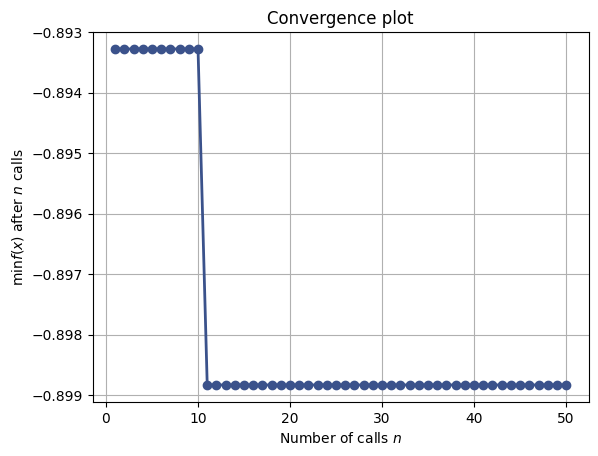

Best accuracy score for GaussianNB: 0.899, Best params: {'var_smoothing': 0.1}


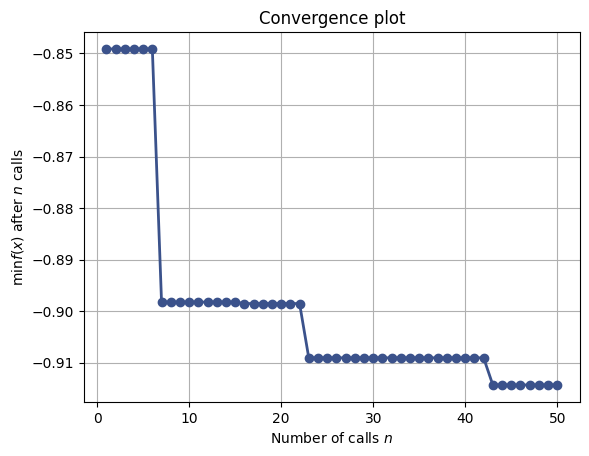

Best accuracy score for SVC: 0.914, Best params: {'C': 0.3855670326785688, 'gamma': 0.10268550127629303}


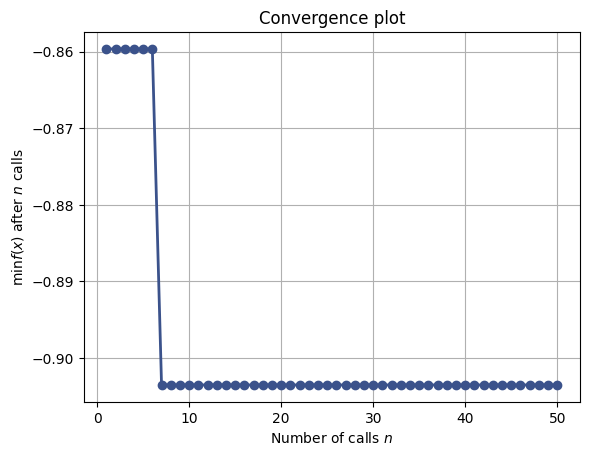

Best accuracy score for LogisticRegression: 0.904, Best params: {'C': 0.05678201970293135, 'max_iter': 201}


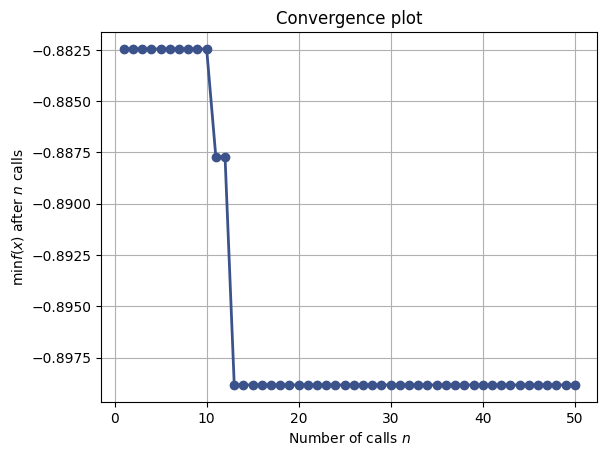

Best accuracy score for RandomForestClassifier: 0.899, Best params: {'n_estimators': 80, 'max_depth': 3}


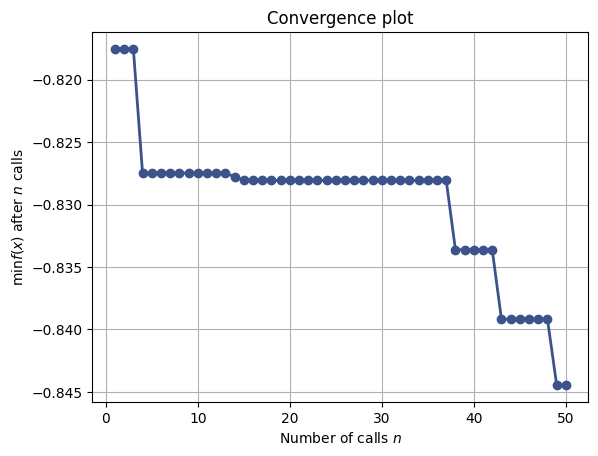

Best accuracy score for GradientBoostingClassifier: 0.844, Best params: {'n_estimators': 300, 'max_depth': 3, 'learning_rate': 0.015337786817803418}


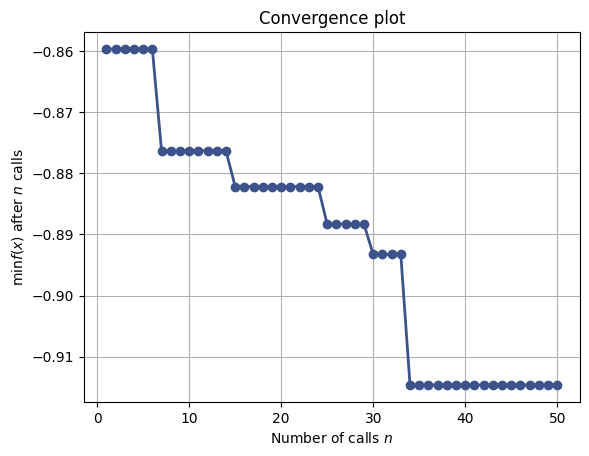

Best accuracy score for MLPClassifier: 0.915, Best params: {'activation': 'tanh', 'max_iter': 113, 'alpha': 1.2378059547265325e-05, 'learning_rate_init': 0.0014023912016084483, 'tol': 1e-05, 'beta_1': 0.999, 'beta_2': 0.9754243239292775}


In [9]:
# Define the hyperparameter search space for each model
lr_space = [Real(1e-5, 1e-1, "log-uniform", name='C'), Integer(200, 2000, name='max_iter')]
svm_space = [Real(1e-5, 2e-0, "log-uniform", name='C'), Real(0.01, 1, name='gamma')]
nb_space = [Real(1e-3, 1e-1, "log-uniform", name='var_smoothing')]
rf_space = [Integer(10, 200, name='n_estimators'), Integer(2, 20, name='max_depth')]
mlp_space = [Categorical(["identity", "logistic", "tanh", "relu"], name="activation"), Integer(50, 1000, name='max_iter'), Real(1e-5, 1e-0, "log-uniform", name='alpha'), Real(1e-5, 1e-1, "log-uniform", name='learning_rate_init'), Real(1e-5, 1e-1, "log-uniform", name='tol'), Real(0.1, 0.999, name='beta_1'), Real(0.1, 0.999, name='beta_2')] # unfortunately, skopt does not support hidden layers for MLPClassifier
gbc_space = [Integer(10, 300, name='n_estimators'), Integer(2, 20, name='max_depth'), Real(0.01, 1, "log-uniform", name='learning_rate')]

# Define a list of models and their corresponding search spaces
models = [
    (GaussianNB(), nb_space),
    (SVC(), svm_space),
    (LogisticRegression(), lr_space),
    (RandomForestClassifier(), rf_space),
    (GradientBoostingClassifier(), gbc_space),
    (MLPClassifier(), mlp_space)
]

best_models = []
scores = {}
plot_scores = {}

# Define the optimization process for each model
for model, space in models:
    # Define the objective function for optimization
    @use_named_args(space)
    def objective(**params):
        model.set_params(**params)
        score = cross_val_score(model, X_train, y_train, cv=10, scoring="accuracy")
        plot_scores[model.__class__.__name__] = score
        score = score.mean()
        # minus because we have to minimize accuracy
        return -score

    res_gp = gp_minimize(objective, space, n_calls=50, random_state=42)
    best_params = {param.name: value for param, value in zip(space, res_gp.x)}
    best_models.append(model.set_params(**best_params))
    scores[model.__class__.__name__] = -res_gp.fun

    plot_convergence(res_gp)
    plt.show()
    print(f"Best accuracy score for {model.__class__.__name__}: {-res_gp.fun:.3f}, Best params: {best_params}")


We chose rather large boundaries for each Model as to not oversee any potential good parameters. As a reference of the range, we chose the default hyperparameters values of the respective models as a centre point. Still, some values lay on the boundaries. These include GaussianNB: var_smoothing (top), SVC: C (top) and Gamma (bottom), Logistic Regression: max_iter (top), GradientBoosting: n_estimators (bottom) and max_depth (bottom), MLP: beta1 (top) & alpha (bottom). We therefore moved the spaces in the respective direction and found that we generally get better results and the parameters are now more centred in the range of possible values in the space. Some hyperparameters still lie on the boundaries even when we pushed these to the most indicating that they are either not really indicative of the solution of the problem at hand or simply are the best possible values.

# Grade 3 #

McNemar's test between Model 1 and Model 2: chi-squared = 0.0, p-value = 1.0
McNemar's test between Model 1 and Model 3: chi-squared = 0.5, p-value = 0.47950012218695337
McNemar's test between Model 1 and Model 4: chi-squared = 0.0, p-value = 1.0
McNemar's test between Model 1 and Model 5: chi-squared = 0.0, p-value = 1.0
McNemar's test between Model 1 and Model 6: chi-squared = 0.0, p-value = 1.0
McNemar's test between Model 2 and Model 3: chi-squared = 0.0, p-value = 1.0
McNemar's test between Model 2 and Model 4: chi-squared = 0.5, p-value = 0.47950012218695337
McNemar's test between Model 2 and Model 5: chi-squared = 0.25, p-value = 0.6170750774519739
McNemar's test between Model 2 and Model 6: chi-squared = 0.5, p-value = 0.47950012218695337
McNemar's test between Model 3 and Model 4: chi-squared = 0.0, p-value = 1.0
McNemar's test between Model 3 and Model 5: chi-squared = 0.0, p-value = 1.0
McNemar's test between Model 3 and Model 6: chi-squared = 0.0, p-value = 1.0
McNemar's te

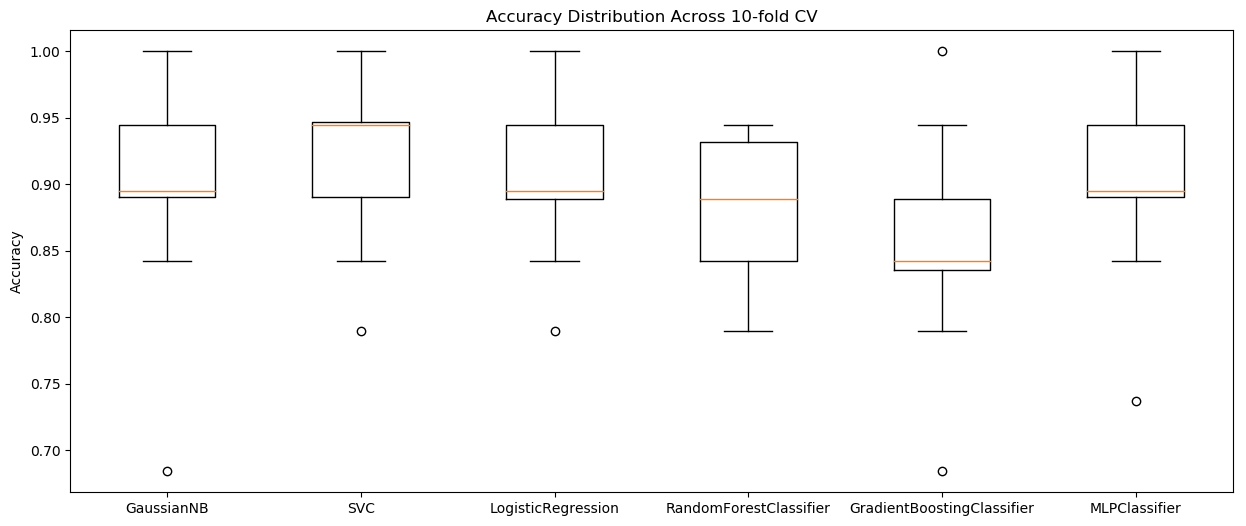

McNemar's test between Model 1 and Model 2: chi-squared = 0.0, p-value = 1.0
McNemar's test between Model 1 and Model 3: chi-squared = 0.5, p-value = 0.47950012218695337
McNemar's test between Model 1 and Model 4: chi-squared = 0.5, p-value = 0.47950012218695337
McNemar's test between Model 1 and Model 5: chi-squared = 1.3333333333333333, p-value = 0.24821307898992026
McNemar's test between Model 1 and Model 6: chi-squared = 0.5, p-value = 0.47950012218695337
McNemar's test between Model 2 and Model 3: chi-squared = 0.0, p-value = 1.0
McNemar's test between Model 2 and Model 4: chi-squared = 0.0, p-value = 1.0
McNemar's test between Model 2 and Model 5: chi-squared = 0.5, p-value = 0.47950012218695337
McNemar's test between Model 2 and Model 6: chi-squared = 0.0, p-value = 1.0
McNemar's test between Model 3 and Model 4: chi-squared = 0.5, p-value = 0.47950012218695337
McNemar's test between Model 3 and Model 5: chi-squared = 0.0, p-value = 1.0
McNemar's test between Model 3 and Model 6

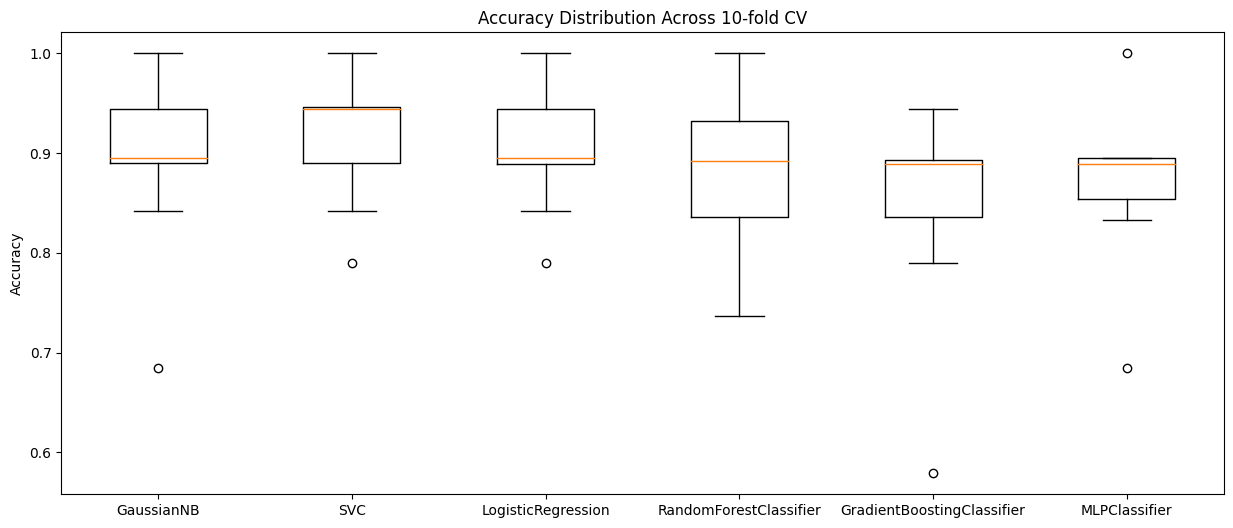

In [10]:
# For storing accuracy scores
cv_scores = []

# For storing predictions for McNemar's test
predictions = []

# For tracking the best model
best_model = None
best_accuracy = 0

for model in best_models:
    # Perform 10-fold cross-validation and store results
    model.fit(X_train, y_train)
    cv_score = cross_val_score(model, X_train, y_train, cv=10)
    cv_scores.append(cv_score)

    # Check if this model is better than the current best
    if np.mean(cv_score) > best_accuracy:
        best_accuracy = np.mean(cv_score)
        best_model = model

    # Make predictions and store them for McNemar's test
    pred = model.predict(X_test)
    predictions.append(pred)

# For tracking the number of significant differences for each model
significant_diffs = [0 for _ in models]

# Perform McNemar's test
for i in range(len(models)):
    for j in range(i+1, len(models)):
        # Create contingency table
        tb = mcnemar_table(y_target=y_test,
                           y_model1=predictions[i],
                           y_model2=predictions[j])

        # Perform McNemar's test
        chi2, p = mcnemar(ary=tb, corrected=True)

        # If p < 0.05, increment the count of significant differences for both models
        if p < 0.05:
            significant_diffs[i] += 1
            significant_diffs[j] += 1

        print(f'McNemar\'s test between Model {i+1} and Model {j+1}: chi-squared = {chi2}, p-value = {p}')

# Find the model with the least number of significant differences
best_mcnemar_model = models[significant_diffs.index(min(significant_diffs))]

print(f'Best model based on cross-validation accuracy: {best_model} with accuracy: {best_accuracy}')
print(f'Best model based on McNemar\'s test: {best_mcnemar_model}')

# Plot accuracy distribution across 10-fold CV for 5 classification algorithms
plt.figure(figsize=(15, 6))
plt.boxplot(cv_scores, labels=[model.__class__.__name__ for model in best_models])
plt.title('Accuracy Distribution Across 10-fold CV')
plt.ylabel('Accuracy')
plt.show()

It seems that the rather simple models are sufficient enough in solving this classification problem. We do however see a difference in the "best" model when using McNemar's test and cross-validation. This could be because with McNemar's test, we are only using one part of the data as a test set while with cross-validation we consider every possible data point in a test set once. Therefore we will use SVC as our best model in the following sections.

# Grade 2 #

In [11]:
print(best_model)

SVC(C=0.3855666569463451, gamma=0.10268567714406111)
SVC(C=0.3855670326785688, gamma=0.10268550127629303)


In [12]:
best_features = []
remaining_features = X_train.columns

converged = False
max_accuracy = 0

while not converged:
    best_feature = None
    max_accuracy_this_round = 0

    for feature in remaining_features:
        # calculate accuracy and compare to previous score
        accuracy = np.average(cross_val_score(best_model, X_train[best_features + [feature]], y_train, cv=10, scoring="accuracy"))
        if accuracy > max_accuracy_this_round:
            max_accuracy_this_round = accuracy
            best_feature = feature

    if len(remaining_features) == 0 or abs(max_accuracy - max_accuracy_this_round) < 1e-7 or max_accuracy_this_round <= max_accuracy:
        converged = True

    # remove best feature from remaining features and add it to best features
    remaining_features = remaining_features.drop(best_feature)
    best_features.append(best_feature)
    max_accuracy = max_accuracy_this_round

best_model.fit(X_train[best_features], y_train)

print(f"best features: {best_features}")
print(f"accuracy of selected features: {best_model.score(X_test[best_features], y_test)}")

best features: ['thal_norm', 'ca', 'cp_asympt', 'restecg_hyp', 'cp_abnang', 'restecg_norm', 'fbs']
accuracy of selected features: 0.7021276595744681
best features: ['thal_norm', 'ca', 'cp_asympt', 'restecg_hyp', 'cp_abnang', 'restecg_norm', 'fbs']
accuracy of selected features: 0.7021276595744681


In [13]:
# perform PCA that retains 95% of the variance
pca = PCA(n_components=0.95)
pca.fit(X_train)
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

best_model.fit(X_train_pca, y_train)
print(f"accuracy of PCA: {best_model.score(X_test_pca, y_test)}")

accuracy of PCA: 0.7872340425531915
accuracy of PCA: 0.7872340425531915


PCA outperforms greedy feature selection.

# Grade 1 #

Permutation explainer: 233it [01:05,  3.04it/s]                         


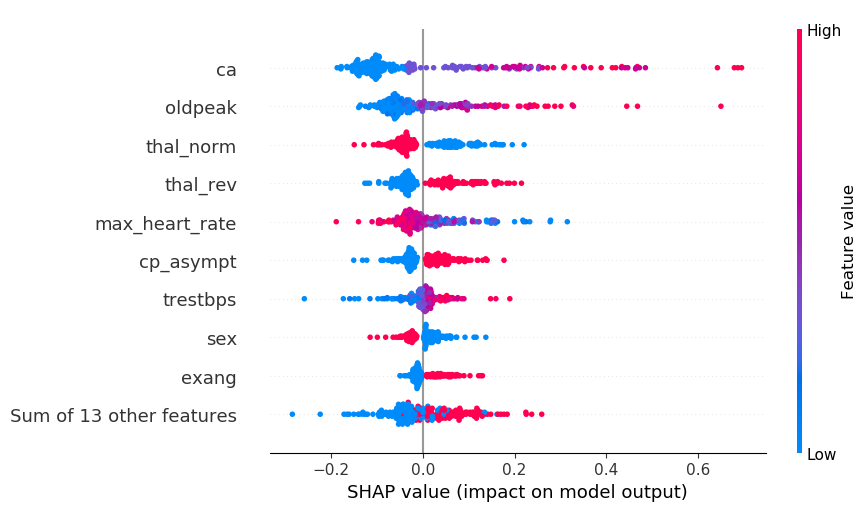

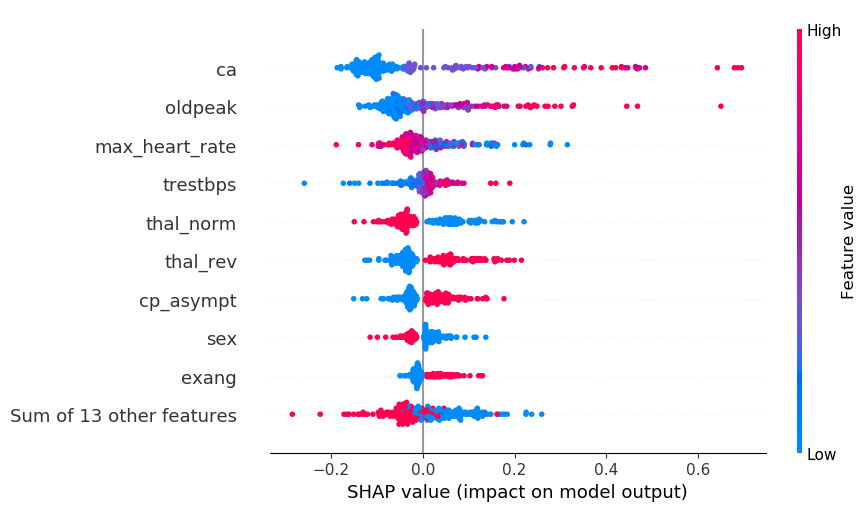

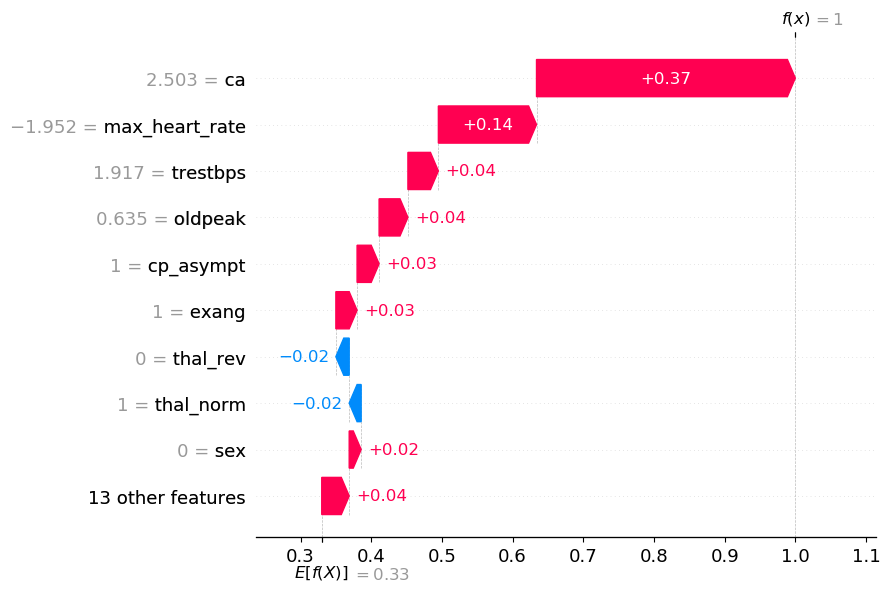

Permutation explainer: 233it [02:20,  1.55it/s]


ValueError: Unable to determine Axes to steal space for Colorbar. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.

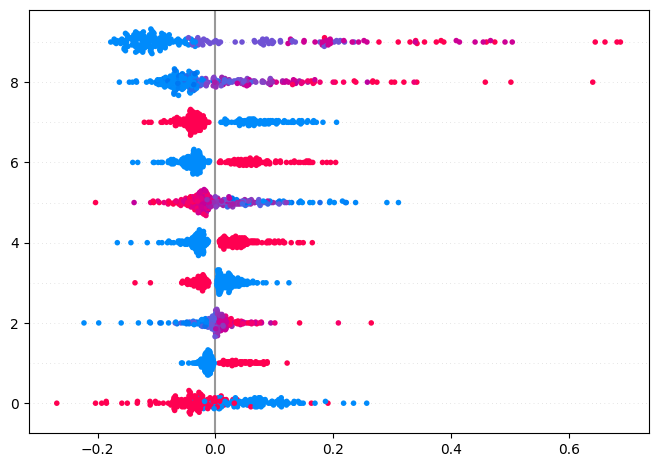

In [14]:
best_model.fit(X_train, y_train)

explainer = Explainer(best_model.predict, X)
shap_values = explainer(X)

beeswarm(shap_values)
beeswarm(shap_values, order=shap_values.abs.max(0))
waterfall(shap_values[0])

We plotted the beeswarm plot once with the features ordered according to their mean SHAP value and once ordered according to their max SHAP value. In both cases "ca" is on the top of the list indicating that this is a very impactful feature. While "oldpeak" has some high SHAP values its distinction between healthy and sick is not as clear as with thal_rev and thal_norm which is why the two categories of the feature "thal" seem more indicative and are to be ranked as the second and third most important features.

In the waterfall plot we see the features ranked by their contribution to the output but only for a single individual prediction. Looking at the we can again confirm ca to be the most impactful while in this case we also see the features that had higher max SHAP values on the top. This could therefore be one of the "outliers" of the SHAP values spectrum. As we can see this individual was predicted to be sick. Below we have plotted a waterfall plot for a healthy patient. Again "ca" is the most impactful now being followed by "thal_norm". This again makes sense since a normal "thal" is indicative of a healthy patient as could be seen from the beeswarm plot.



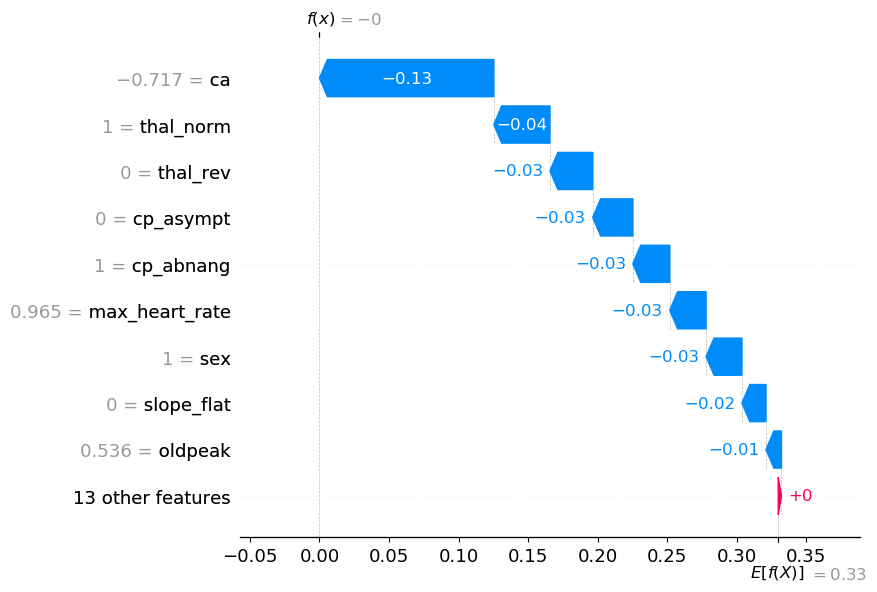

In [0]:
waterfall(shap_values[2])ificant differences


In comparison to the greedy feature selection we actually see a different ordering of the importance of the features. While greedy feature selection did not pick "ca" as the first feature, we see a clear indication by the SHAP values that it is the most impactful. Also worth noting "age" is picked by greedy feature selection while in the SHAP values ranking it is merely summarised with the other less impactful features when looking at the SHAP analysis.

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=25bc7c43-e4d6-4312-85d4-e0aceaccd0d9' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>